# EDA and feature engineering

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc

In [2]:
DATA_DIR = "../data/final_project/"
# sales
sales_train = pd.read_csv(DATA_DIR+"sales_train.csv")
sales_test = pd.read_csv(DATA_DIR+"test.csv")

# addional info
items = pd.read_csv(DATA_DIR+"items.csv")
item_categories = pd.read_csv(DATA_DIR+"item_categories.csv")
shops = pd.read_csv(DATA_DIR+"shops.csv")

## Data transformation

### Daily item count & price

,count,mean,std,min,0.1%,1%,50%,99%,99.9%,max
item_cnt_day,2935849.0,1.242641,2.618834,-22.0,-1.0,1.0,1.0,5.0,22.0,2169.0
item_price,2935849.0,890.853233,1729.799631,-1.0,0.1,5.0,399.0,5999.0,23990.0,307980.0


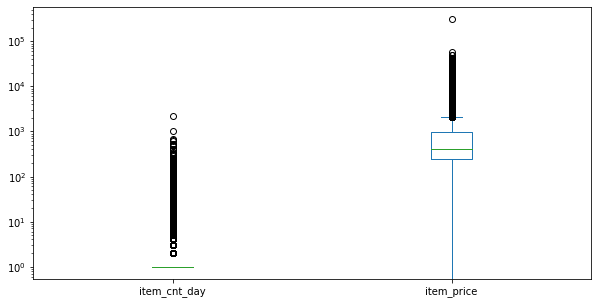

In [3]:
display(sales_train[["item_cnt_day","item_price"]].describe(percentiles=[0.001,0.01,0.990,0.999]).T);
fig, ax = plt.subplots(1,1,figsize=(10,5))
sales_train[["item_cnt_day","item_price"]].plot(kind="box",logy=True, ax=ax);

In [4]:
sales_train["item_cnt_day"] = sales_train["item_cnt_day"].clip(0,25)
sales_train["item_price"] = sales_train["item_price"].clip(0.1,25000)
sales_train["revenue"] = sales_train.item_cnt_day*sales_train.item_price
items

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
...,...,...,...
22165,"Ядерный титбит 2 [PC, Цифровая версия]",22165,31
22166,Язык запросов 1С:Предприятия [Цифровая версия],22166,54
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49
22168,Яйцо для Little Inu,22168,62


### Duplicated entities based on text representation

In [5]:
# categories
from itertools import product
from fuzzywuzzy import fuzz

cat_pairs = pd.DataFrame(list(product(shops.shop_id.unique(),shops.shop_id.unique())),
    columns=["from","to"])
cat_pairs = cat_pairs[cat_pairs["from"]<cat_pairs["to"]]
cat_pairs["tf"] = item_categories.item_category_name[cat_pairs["from"]].values
cat_pairs["tt"] = item_categories.item_category_name[cat_pairs["to"]].values
cat_pairs["similarity"] = cat_pairs.apply(lambda x: fuzz.ratio(x["tf"],x["tt"]), axis=1)
cat_pairs.sort_values("similarity").tail(10)

,from,to,tf,tt,similarity
124,2,4,Аксессуары - PS3,Аксессуары - PSP,94
123,2,3,Аксессуары - PS3,Аксессуары - PS4,94
184,3,4,Аксессуары - PS4,Аксессуары - PSP,94
63,1,3,Аксессуары - PS2,Аксессуары - PS4,94
673,11,13,Игровые консоли - PS3,Игровые консоли - PSP,95
733,12,13,Игровые консоли - PS4,Игровые консоли - PSP,95
613,10,13,Игровые консоли - PS2,Игровые консоли - PSP,95
672,11,12,Игровые консоли - PS3,Игровые консоли - PS4,95
611,10,11,Игровые консоли - PS2,Игровые консоли - PS3,95
612,10,12,Игровые консоли - PS2,Игровые консоли - PS4,95


In [6]:
# shops
shop_pairs = pd.DataFrame(list(product(shops.shop_id.unique(),shops.shop_id.unique())),
    columns=["from","to"])
shop_pairs = shop_pairs[shop_pairs["from"]<shop_pairs["to"]]
shop_pairs["tf"] = shops.shop_name[shop_pairs["from"]].values
shop_pairs["tt"] = shops.shop_name[shop_pairs["to"]].values
shop_pairs["similarity"] = shop_pairs.apply(lambda x: fuzz.ratio(x["tf"],x["tt"]), axis=1)
shop_pairs.sort_values("similarity").tail(10)

,from,to,tf,tt,similarity
3178,52,58,"Уфа ТК ""Центральный""","Якутск ТЦ ""Центральный""",74
885,14,45,"Казань ТЦ ""ПаркХаус"" II","Самара ТЦ ""ПаркХаус""",74
1648,27,28,"Москва ТЦ ""МЕГА Белая Дача II""","Москва ТЦ ""МЕГА Теплый Стан"" II",75
2334,38,54,"Омск ТЦ ""Мега""","Химки ТЦ ""Мега""",83
1831,30,31,"Москва ТЦ ""Перловский""","Москва ТЦ ""Семеновский""",84
57,0,57,"!Якутск Орджоникидзе, 56 фран","Якутск Орджоникидзе, 56",88
118,1,58,"!Якутск ТЦ ""Центральный"" фран","Якутск ТЦ ""Центральный""",88
2380,39,40,"РостовНаДону ТРК ""Мегацентр Горизонт""","РостовНаДону ТРК ""Мегацентр Горизонт"" Островной",88
1404,23,24,"Москва ТК ""Буденовский"" (пав.А2)","Москва ТК ""Буденовский"" (пав.К7)",94
611,10,11,Жуковский ул. Чкалова 39м?,Жуковский ул. Чкалова 39м²,96


In [7]:
# reduce duplicates
filter_pairs = shop_pairs[shop_pairs.similarity>80]
temp = sales_train.merge(filter_pairs, left_on="shop_id", right_on="to", how="left").loc[:,["from","shop_id"]]
sales_train["shop_id"] = temp["from"].combine_first(temp["shop_id"]).astype(int) #coalesce
temp = sales_test.merge(filter_pairs, left_on="shop_id", right_on="to", how="left").loc[:,["from","shop_id"]]
sales_test["shop_id"] = temp["from"].combine_first(temp["shop_id"]).astype(int)

In [8]:
# too slow :(
# item_pairs = items.merge(items, on="item_category_id", suffixes=["_from","_to"])
# item_pairs = item_pairs[item_pairs.item_name_from<item_pairs.item_name_to]
# item_pairs["similarity"] = item_pairs.apply(\
#     lambda x: fuzz.ratio(x["item_name_from"],x["item_name_to"]), axis=1)
# item_pairs.sort_values("similarity").tail(10)

In [9]:
# expand the dataset
shop_item_month = product(sales_train.shop_id.unique(), sales_train.item_id.unique(), sales_train.date_block_num.unique())
sales_index = pd.DataFrame(list(shop_item_month), columns=["shop_id","item_id","date_block_num"])

In [10]:
agg_sales_train = sales_train.groupby(["shop_id", "item_id", "date_block_num"], as_index=False).agg(
    total_sold=("item_cnt_day", sum), avg_price=("item_price",np.mean),
    sum_revenue=("revenue",sum), n_transactions = ("item_cnt_day",pd.Series.count)).sort_values("date_block_num")
agg_sales_train = sales_index.merge(agg_sales_train, on=["shop_id", "item_id", "date_block_num"], how="left").fillna(0)    
agg_sales_train.head()    

,shop_id,item_id,date_block_num,total_sold,avg_price,sum_revenue,n_transactions
0,59,22154,0,1.0,999.0,999.0,1.0
1,59,22154,1,0.0,0.0,0.0,0.0
2,59,22154,2,0.0,0.0,0.0,0.0
3,59,22154,3,0.0,0.0,0.0,0.0
4,59,22154,4,0.0,0.0,0.0,0.0


In [11]:
# do the casting
fcols = agg_sales_train.select_dtypes("float").columns
icols = agg_sales_train.select_dtypes("integer").columns
agg_sales_train[fcols] = agg_sales_train[fcols].apply(pd.to_numeric, downcast="float")
agg_sales_train[icols] = agg_sales_train[icols].apply(pd.to_numeric, downcast="integer")
agg_sales_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39296214 entries, 0 to 39296213
Data columns (total 7 columns):
 #   Column          Dtype  
---  ------          -----  
 0   shop_id         int8   
 1   item_id         int16  
 2   date_block_num  int8   
 3   total_sold      float32
 4   avg_price       float32
 5   sum_revenue     float32
 6   n_transactions  float32
dtypes: float32(4), int16(1), int8(2)
memory usage: 1.0 GB


In [12]:
# lags on item-shop-month
lags = [1,2,3,6]
for l in lags:
    agg_sales_train["lag"+str(l)+"_total_sold"]=agg_sales_train["total_sold"].\
        groupby([agg_sales_train.shop_id,agg_sales_train.item_id]).\
            shift(l).cumsum().fillna(0)

# price change on item-shop-month
agg_sales_train["price_increase"]=(agg_sales_train["avg_price"]/\
    agg_sales_train["avg_price"].groupby([agg_sales_train.shop_id,agg_sales_train.item_id]).\
        shift(1)).fillna(1)#.clip(0,10)            

# item-month
lags = [1,2,3,6]
item_lags = agg_sales_train["total_sold"].\
    groupby([agg_sales_train.date_block_num, agg_sales_train.item_id]).sum().fillna(0).reset_index().\
        rename(columns={"total_sold":"item_sold"})
for l in lags:
    item_lags["date_block_num_lag"+str(l)]=item_lags.date_block_num-l
    agg_sales_train = agg_sales_train.merge(item_lags.loc[:,["item_id", "date_block_num_lag"+str(l), "item_sold"]],
        how="left", left_on=["item_id", "date_block_num"], right_on=["item_id", "date_block_num_lag"+str(l)]).\
            rename(columns={"item_sold": "lag"+str(l)+"item_sold"}).fillna(-1)
del item_lags

# shop-month
lags = [1,2,3,6]
shop_lags = agg_sales_train["total_sold"].\
    groupby([agg_sales_train.date_block_num, agg_sales_train.shop_id]).sum().fillna(0).reset_index().\
        rename(columns={"total_sold":"shop_sold"})
for l in lags:
    shop_lags["date_block_num_lag"+str(l)]=shop_lags.date_block_num-l
    agg_sales_train = agg_sales_train.merge(shop_lags.loc[:,["shop_id", "date_block_num_lag"+str(l), "shop_sold"]],
        how="left", left_on=["shop_id", "date_block_num"], right_on=["shop_id", "date_block_num_lag"+str(l)]).\
            rename(columns={"shop_sold": "lag"+str(l)+"shop_sold"}).fillna(-1)

del shop_lags
gc.collect()

# CLEAN THIS UP

2054

In [13]:
# target transformation
agg_sales_train["target"] = agg_sales_train["total_sold"].\
        groupby([agg_sales_train.shop_id,agg_sales_train.item_id]).shift(-1).\
            fillna(0).clip(0,20)

In [14]:
target = "target"
features = [c!=target for c in agg_sales_train.columns]

In [15]:
# fast tree bench
from lightgbm import LGBMRegressor
steps = range(32,34)
rsme_ls = []
for step in steps:
    last_block = agg_sales_train.date_block_num.max()-step
    train = agg_sales_train[agg_sales_train.date_block_num<last_block]
    test = agg_sales_train[agg_sales_train.date_block_num==last_block]
    gbm = LGBMRegressor()
    gbm.fit(train.loc[:,features], train.loc[:,target])
    train_rsme = np.mean((gbm.predict(train.loc[:,features]).clip(0,20)-\
        train.loc[:,target])**2)**(1/2)
    test_rsme = np.mean((gbm.predict(test.loc[:,features]).clip(0,20)-\
        test.loc[:,target])**2)**(1/2)
    rsme_ls.append((last_block, train_rsme, test_rsme))   

[LightGBM] [Fatal] Check failed: num_data > 0 at /home/travis/build/Microsoft/LightGBM/python-package/lightgbm/src/io/dataset.cpp, line 27 .



LightGBMError: b'Check failed: num_data > 0 at /home/travis/build/Microsoft/LightGBM/python-package/lightgbm/src/io/dataset.cpp, line 27 .\n'

In [ ]:
rmse_df = pd.DataFrame(rsme_ls, columns=["test_block", "train_rmse","test_rmse"])
print("Mean train RMSE: {}".format(rmse_df.train_rmse.mean()))
print("Std train RMSE: {}".format(rmse_df.train_rmse.std()))   
print("Mean test RMSE: {}".format(rmse_df.test_rmse.mean()))
print("Std test RMSE: {}".format(rmse_df.test_rmse.std()))   

fig, ax = plt.subplots(1,1,figsize=(10,7))
ax.scatter(x=rmse_df.test_block, y=rmse_df.train_rmse, c="blue");
ax.scatter(x=rmse_df.test_block, y=rmse_df.test_rmse, c="red");
ax.set_xlabel("test block");
ax.set_ylabel("rmse");

In [ ]:
# predict on test set
test_data = sales_test.merge(agg_sales_train[agg_sales_train.date_block_num==33],
    on=["shop_id", "item_id"], how="left").fillna(0)
test_features = [c not in [target, "ID"] for c in test_data.columns]
test_predictions = gbm.predict(test_data.loc[:,test_features]).clip(0,20)

In [ ]:
# submission, uncomment on new features
#pd.concat([test_data.ID, pd.Series(test_predictions, name="item_cnt_month")], axis=1).\
#    to_csv("../data/submissions/submission.csv", index=False)
#!kaggle competitions submit -c competitive-data-science-predict-future-sales -f ../data/submissions/submission.csv -m "Try lagged avgs."

In [ ]:
# NOTE: consider item totals, moving averages and differencing